## Introduction

Since 1980, more than 229,000 Americans have been killed in homicides that have gone unsolved. To put that into perspective, this number is higher than the combined death toll of all American military actions since WWII. Every single year, over 5,000 killers get away with murder, an average of about 14 every single day. Surprisingly, no department exists that monitors unsolved homicide cases or even tracks them. This effort is left entirely to the local police departments and self reporting.

The Murder Accountability Project is a nonprofit group organized in 2015 and dedicated to educate Americans on the importance of accurately accounting for unsolved homicides within the United States. They obtain information from federal, state and local governments about unsolved homicides and publish this information for anyone to access.

## The Data

The data used in this project ranges from 1984 to 2014. There are over 630,000 cases in this time of both solved and unsolved cases. There are 23 features in this dataset including the location, month and year, victim and perpetrator demographic information including ethnicity, age, sex and race, the relationship to the victim, the weapon used, and more.

## Goal

The primary goal of this project is to attempt to predict the demographic infomration of perpetrators in unsolved homicides using data from solved cases. Several different classifier models will be implemented in order to compare effeciancy rates.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline

In [2]:
df = pd.read_csv('homicide_reports.csv', low_memory=False)
print(df.shape)
print(df.columns)
df.head()

(638454, 24)
Index(['Record ID', 'Agency Code', 'Agency Name', 'Agency Type', 'City',
       'State', 'Year', 'Month', 'Incident', 'Crime Type', 'Crime Solved',
       'Victim Sex', 'Victim Age', 'Victim Race', 'Victim Ethnicity',
       'Perpetrator Sex', 'Perpetrator Age', 'Perpetrator Race',
       'Perpetrator Ethnicity', 'Relationship', 'Weapon', 'Victim Count',
       'Perpetrator Count', 'Record Source'],
      dtype='object')


,Record ID,Agency Code,Agency Name,Agency Type,City,State,Year,Month,Incident,Crime Type,...,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count,Record Source
0,1,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,January,1,Murder or Manslaughter,...,Unknown,Male,15,Native American/Alaska Native,Unknown,Acquaintance,Blunt Object,0,0,FBI
1,2,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
2,3,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,March,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,0,FBI
3,4,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,1,Murder or Manslaughter,...,Unknown,Male,42,White,Unknown,Acquaintance,Strangulation,0,0,FBI
4,5,AK00101,Anchorage,Municipal Police,Anchorage,Alaska,1980,April,2,Murder or Manslaughter,...,Unknown,Unknown,0,Unknown,Unknown,Unknown,Unknown,0,1,FBI


In [3]:
#make the feature headings more python friendly
words = [w.replace(' ', '_') for w in df.columns]
words = [w.lower() for w in words]
df.columns = words
df.dtypes

record_id                 int64
agency_code              object
agency_name              object
agency_type              object
city                     object
state                    object
year                      int64
month                    object
incident                  int64
crime_type               object
crime_solved             object
victim_sex               object
victim_age                int64
victim_race              object
victim_ethnicity         object
perpetrator_sex          object
perpetrator_age          object
perpetrator_race         object
perpetrator_ethnicity    object
relationship             object
weapon                   object
victim_count              int64
perpetrator_count         int64
record_source            object
dtype: object

In [4]:
#dislay the number of unique value types in each feature
for col in df:
    print('Unique ' + col + ' variables:', df[col].nunique())

Unique record_id variables: 638454
Unique agency_code variables: 12003
Unique agency_name variables: 9216
Unique agency_type variables: 7
Unique city variables: 1782
Unique state variables: 51
Unique year variables: 35
Unique month variables: 12
Unique incident variables: 1000
Unique crime_type variables: 2
Unique crime_solved variables: 2
Unique victim_sex variables: 3
Unique victim_age variables: 101
Unique victim_race variables: 5
Unique victim_ethnicity variables: 3
Unique perpetrator_sex variables: 3
Unique perpetrator_age variables: 101
Unique perpetrator_race variables: 5
Unique perpetrator_ethnicity variables: 3
Unique relationship variables: 28
Unique weapon variables: 16
Unique victim_count variables: 11
Unique perpetrator_count variables: 11
Unique record_source variables: 2


## Feature Engineering and Selection

There are 4 features that will not be helpful to our analysis. They are unqiue codes for law enformcement and are either redudant or don't contribute to our analysis. As such record id, agency code, agency neame, and incident will be dropped. Any non-numeric feature is converted into categorical variable types. Features are cleaned up, spelling mistakes fixed, etc. A new feature is created to match how the FBI categorizes unsolved crimes. If the crime goes unsolved, obviously we can't know the perpetrator's demographic information. With age, law enforcement does try to predict an exact age, but rather gives an age rage. As such, I created a feature that turned age into a age range categories.

Feature selection algorthims were also run to confirm that these features had minimal impact on our model. Features that explained less than 1% of variance in all cases were dropped.

In [5]:
#drop features that are just unqiue codes for law enforcement and are not helpful to analysis
df = df.drop(['record_id', 'agency_code', 'agency_name', 'incident'], 1)

In [6]:
#convert several features category types
for cols in ['agency_type', 'state', 'crime_type', 'victim_sex', 'victim_race', 'victim_ethnicity',
        'perpetrator_sex', 'perpetrator_race', 'perpetrator_ethnicity', 'relationship', 'weapon',
         'record_source']:
    df[cols] = df[cols].astype('category')
    
#convert perpetrator age to integer
df['perpetrator_age'] = df['perpetrator_age'].replace(' ', 0)
df['perpetrator_age'] = df['perpetrator_age'].astype('int64')

#covert month and year to a single datetime format
#df['month'] = df['month'].astype(str)
#df['year'] = df['year'].astype(str)
#df['date'] = df['month'] + ' ' + df['year']
#df['date'] = pd.to_datetime(df['date'], format='%B %Y')

#change 'Native American/Alaska Native' to 'Indigenous'
df['perpetrator_race'] = df['perpetrator_race'].replace('Native American/Alaska Native', 'Indigenous')
df['victim_race'] = df['victim_race'].replace('Native American/Alaska Native', 'Indigenous')

#change 'Rhodes Island' to 'Rhode'
df['state'] = df['state'].replace('Rhodes Island', 'Rhode Island')

#create age brackets
age_class = []
for value in df['perpetrator_age']:
    if value < 15:
        age_class.append('Under 15')
    elif 15 <= value < 25:
        age_class.append('15 - 24')
    elif 25 <= value < 35:
        age_class.append('25 - 34')
    elif 35 <= value < 45:
        age_class.append('35 - 44')
    elif 45 <= value < 55:
        age_class.append('45 - 54')
    elif 55 <= value < 65:
        age_class.append('55 - 64')
    elif 65 <= value < 75:
        age_class.append('65 - 74')
    else:
        age_class.append('Over 75')
        
df['perp_age_bracket'] = age_class

In [7]:
#function to quickly group by a feature
def group_features(feature):
    feature_df = pd.DataFrame(df.groupby(feature).size())
    feature_df = feature_df.reset_index()
    feature_df = feature_df.rename(index=str, columns={0: 'murders'})
    return feature_df

In [8]:
n = 0
clearance_list = []
for x in df.groupby(['year', 'crime_solved']).size():
    if n % 2 != 0:
        clearance_list.append(x)
    n += 1

In [9]:
year_df = group_features('year')
year_df = year_df.astype(int)
year_df['solved_crimes'] = clearance_list
year_df['clearance_rate'] = year_df['solved_crimes'] / year_df['murders']

## Data Exploration

There is a massive amount of data available here, so we will look over what we can related to our analysis. A quick list of some of the observations you can view below:

- Murders per year have gone down since the 1980s.
- Clearance rates decreased between 1980 and the early 90s, but have gone up slightly sense then.
- There are incorrect ages input into the system that need to be corrected for (998 year olds).
- The largest percentage of both victims and perpetrators are between 15 and 30.
- There appear to be significant difference in clearance rates between race, sex, and age.
- Different states have drastically different clearance rates.

There are hundreds of interesting observations to find, and explore.


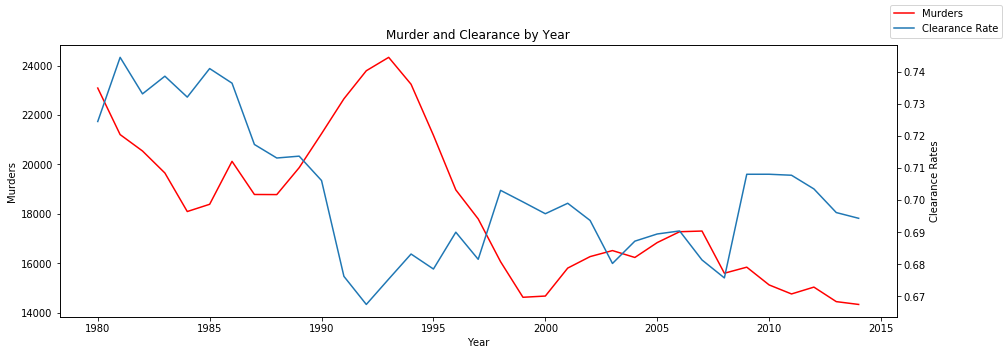

In [59]:
plt.figure(figsize=(15, 5))
ax = sns.lineplot(x='year', y='murders', data=year_df, color='r', label='Murders', legend=False)
ax2 = ax.twinx()
sns.lineplot(x='year', y='clearance_rate', data=year_df, ax=ax2, label='Clearance Rate', legend=False)
ax.figure.legend()
ax.set_ylabel('Murders')
ax2.set_ylabel('Clearance Rates')
ax.set_xlabel('Year')
plt.title('Murder and Clearance by Year')

plt.show()

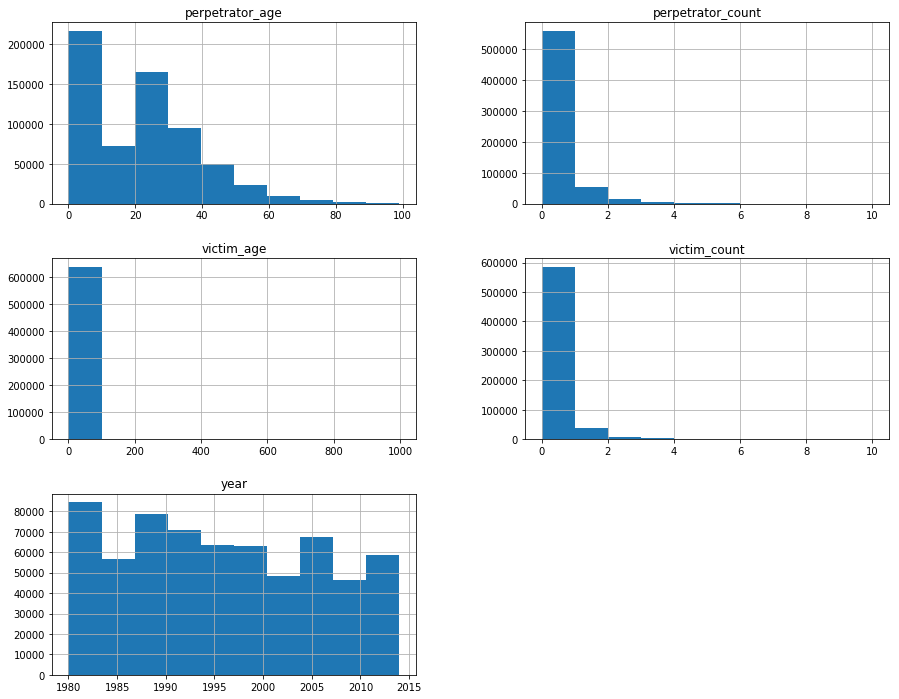

In [11]:
#look at the distribution of all remaining integers types
(df.select_dtypes(include=['int64'])).hist(figsize=(15,12))
plt.show()

In [12]:
#data cleaning
age_df = df.copy()
age_df = age_df[age_df['perpetrator_age'] > 0]
age_df = age_df[age_df['victim_age'] < 99]

In [13]:
#create two dataframes, one where the homicide was solved and one where it was not
crime_solved = age_df[age_df['crime_solved'] == 'Yes']
crime_unsolved = age_df[age_df['crime_solved'] == 'No']

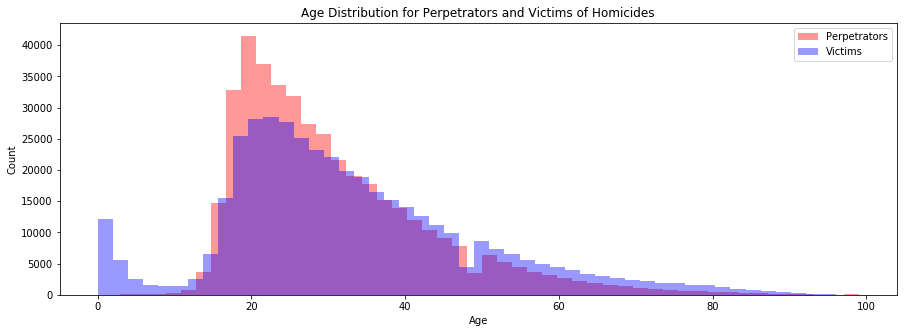

In [14]:
#age distribution of victims and perps by year
plt.figure(figsize=(15, 5))
sns.distplot(age_df['perpetrator_age'].dropna(), color='red', kde=False, label='Perpetrators')
sns.distplot(age_df['victim_age'].dropna(), color='blue', kde=False, label='Victims')
#sns.distplot(crime_unsolved['victim_age'].dropna(), color='red', kde=False, label='Unsolved Victims')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution for Perpetrators and Victims of Homicides')
plt.legend()

plt.show()

In [15]:
#functions that will create heatmap plot for two crosses features
def norm_heatmap_plot(col1, col2):
    crosstab = pd.crosstab(df[col1], df[col2], normalize='columns')
    plot = sns.heatmap(crosstab, annot=True, linewidths=.5, cmap='coolwarm', cbar=False)
    return plot

def normrow_heatmap_plot(col1, col2):
    crosstab = pd.crosstab(df[col1], df[col2], normalize='index')
    plot = sns.heatmap(crosstab, annot=True, linewidths=.5, cmap='coolwarm', cbar=False)
    return plot

def heatmap_plot(col1, col2):
    crosstab = pd.crosstab(df[col1], df[col2])
    plot = sns.heatmap(crosstab, annot=True, linewidths=.5, cmap='coolwarm', cbar=False, fmt='d')
    return plot

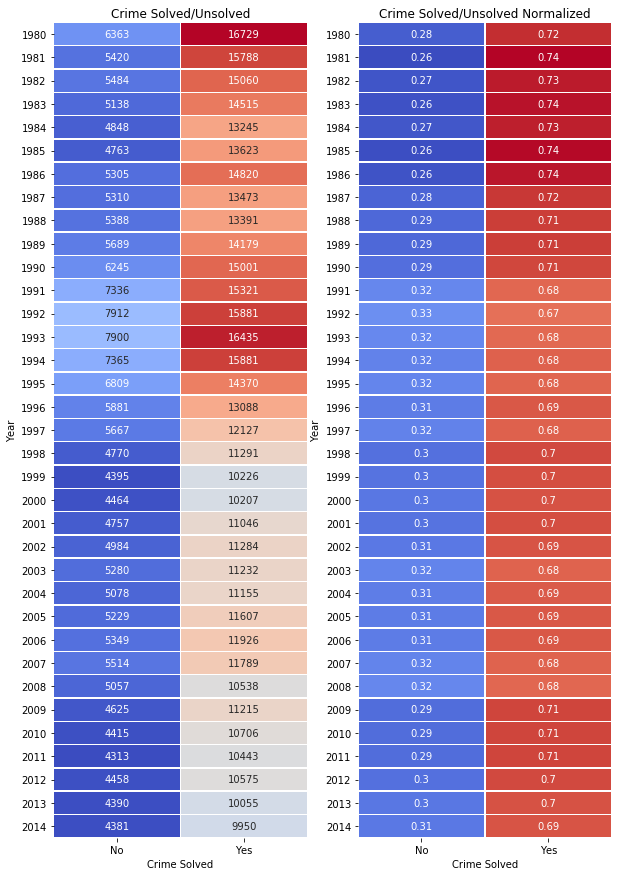

In [16]:
#crimes solved by year
plt.figure(figsize=(10, 15))

plt.subplot(1, 2, 1)
heatmap_plot('year', 'crime_solved')
plt.yticks(rotation='horizontal')
plt.ylabel('Year')
plt.xlabel('Crime Solved')
plt.title('Crime Solved/Unsolved')

plt.subplot(1, 2, 2)
normrow_heatmap_plot('year', 'crime_solved')
plt.yticks(rotation='horizontal')
plt.ylabel('Year')
plt.xlabel('Crime Solved')
plt.title('Crime Solved/Unsolved Normalized')

plt.show()

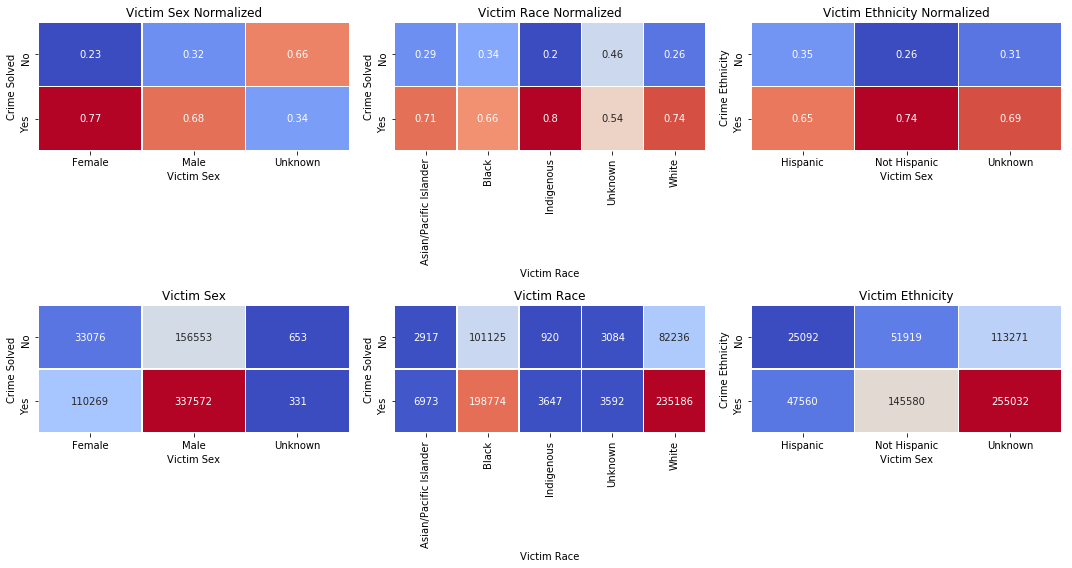

In [17]:
#breakdown of victim race, sex and ethnicity
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
norm_heatmap_plot('crime_solved', 'victim_sex')
plt.title('Victim Sex Normalized')
plt.xlabel('Victim Sex')
plt.ylabel('Crime Solved')

plt.subplot(2, 3, 2)
norm_heatmap_plot('crime_solved', 'victim_race')
plt.title('Victim Race Normalized')
plt.xlabel('Victim Race')
plt.ylabel('Crime Solved')

plt.subplot(2, 3, 3)
norm_heatmap_plot('crime_solved', 'victim_ethnicity')
plt.title('Victim Ethnicity Normalized')
plt.xlabel('Victim Sex')
plt.ylabel('Crime Ethnicity')

plt.subplot(2, 3, 4)
heatmap_plot('crime_solved', 'victim_sex')
plt.title('Victim Sex')
plt.xlabel('Victim Sex')
plt.ylabel('Crime Solved')

plt.subplot(2, 3, 5)
heatmap_plot('crime_solved', 'victim_race')
plt.title('Victim Race')
plt.xlabel('Victim Race')
plt.ylabel('Crime Solved')

plt.subplot(2, 3, 6)
heatmap_plot('crime_solved', 'victim_ethnicity')
plt.title('Victim Ethnicity')
plt.xlabel('Victim Sex')
plt.ylabel('Crime Ethnicity')

plt.tight_layout()
plt.show()

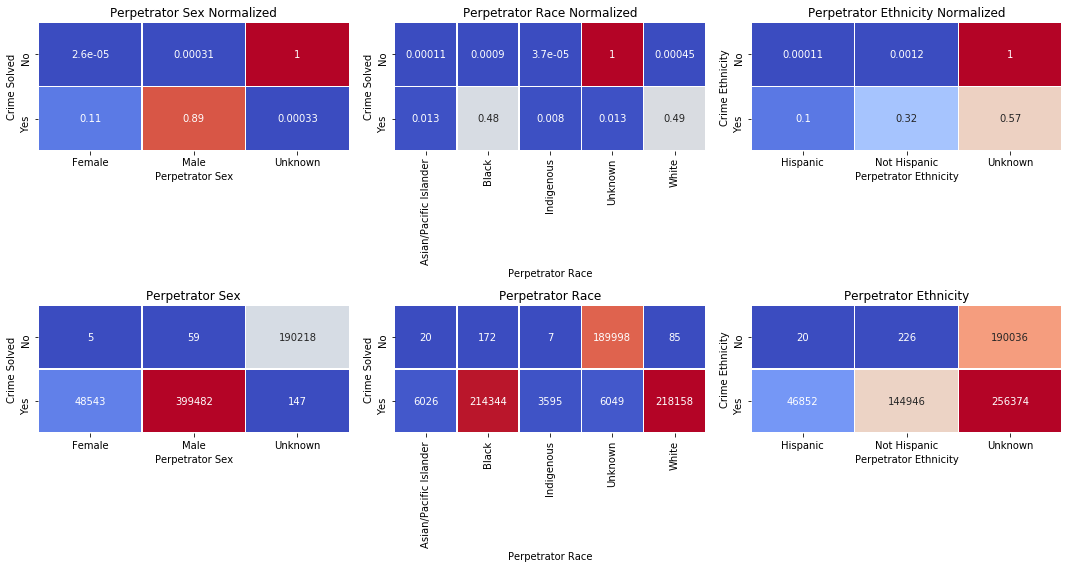

In [18]:
#breakdown of perpetrator race, sex and ethnicity
plt.figure(figsize=(15, 8))

plt.subplot(2, 3, 1)
normrow_heatmap_plot('crime_solved', 'perpetrator_sex')
plt.title('Perpetrator Sex Normalized')
plt.xlabel('Perpetrator Sex')
plt.ylabel('Crime Solved')

plt.subplot(2, 3, 2)
normrow_heatmap_plot('crime_solved', 'perpetrator_race')
plt.title('Perpetrator Race Normalized')
plt.xlabel('Perpetrator Race')
plt.ylabel('Crime Solved')

plt.subplot(2, 3, 3)
normrow_heatmap_plot('crime_solved', 'perpetrator_ethnicity')
plt.title('Perpetrator Ethnicity Normalized')
plt.xlabel('Perpetrator Ethnicity')
plt.ylabel('Crime Ethnicity')

plt.subplot(2, 3, 4)
heatmap_plot('crime_solved', 'perpetrator_sex')
plt.title('Perpetrator Sex')
plt.xlabel('Perpetrator Sex')
plt.ylabel('Crime Solved')

plt.subplot(2, 3, 5)
heatmap_plot('crime_solved', 'perpetrator_race')
plt.title('Perpetrator Race')
plt.xlabel('Perpetrator Race')
plt.ylabel('Crime Solved')

plt.subplot(2, 3, 6)
heatmap_plot('crime_solved', 'perpetrator_ethnicity')
plt.title('Perpetrator Ethnicity')
plt.xlabel('Perpetrator Ethnicity')
plt.ylabel('Crime Ethnicity')

plt.tight_layout()
plt.show()

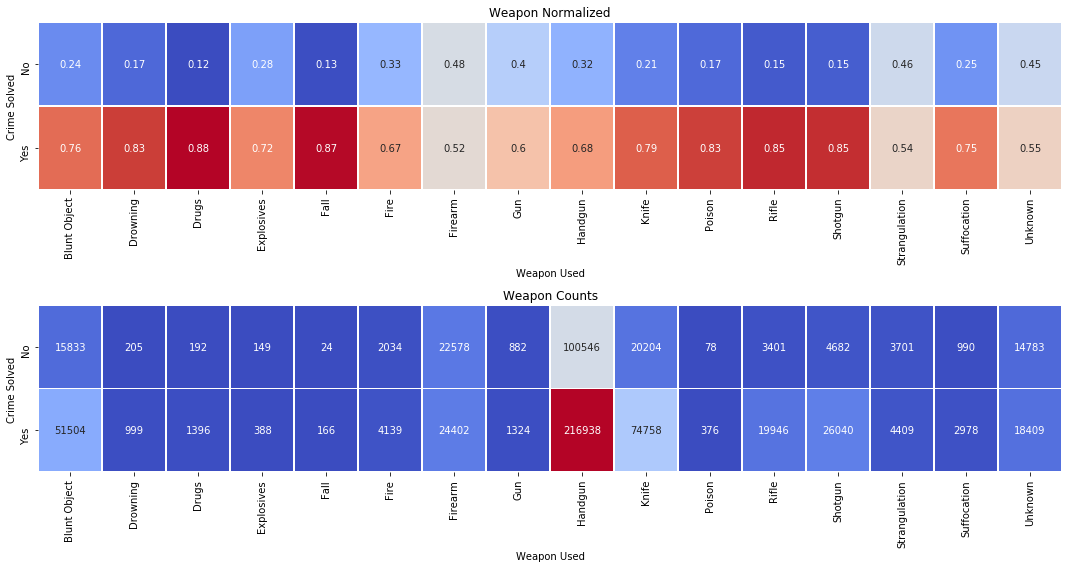

In [19]:
#breakdown of homicides solved by weapon used
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
norm_heatmap_plot('crime_solved', 'weapon')
plt.title('Weapon Normalized')
plt.xlabel('Weapon Used')
plt.ylabel('Crime Solved')

plt.subplot(2, 1, 2)
heatmap_plot('crime_solved', 'weapon')
plt.title('Weapon Counts')
plt.xlabel('Weapon Used')
plt.ylabel('Crime Solved')

plt.tight_layout()
plt.show()

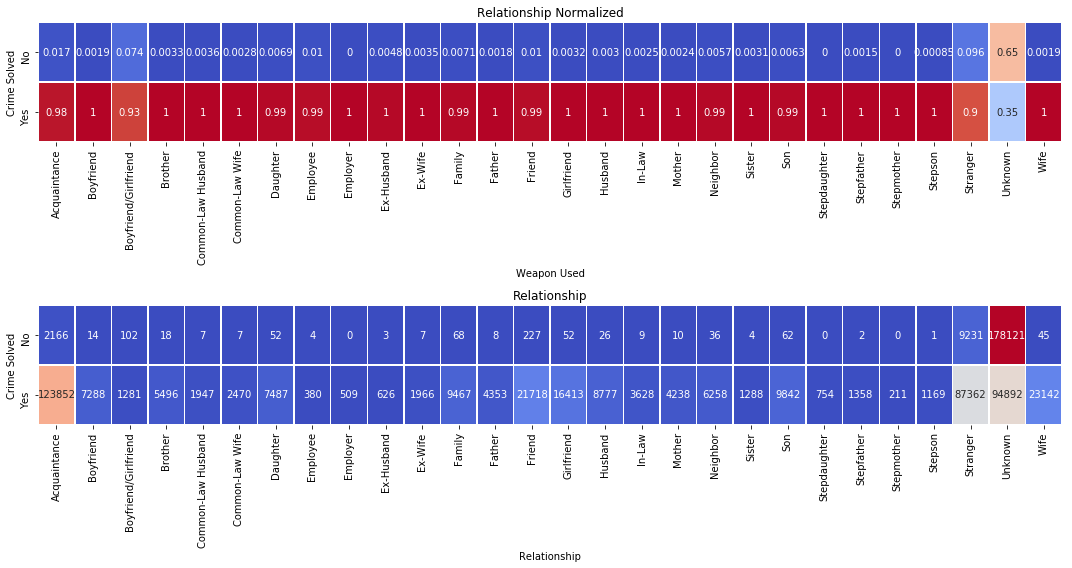

In [20]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
norm_heatmap_plot('crime_solved', 'relationship')
plt.title('Relationship Normalized')
plt.xlabel('Weapon Used')
plt.ylabel('Crime Solved')

plt.subplot(2, 1, 2)
heatmap_plot('crime_solved', 'relationship')
plt.title('Relationship')
plt.xlabel('Relationship')
plt.ylabel('Crime Solved')

plt.tight_layout()
plt.show()

In [21]:
#create a crosstab of state and crime solved that is normalized by state
state_clearance = pd.crosstab(df['state'], df['crime_solved'], normalize='index')

In [22]:
#create a dataframe with states, and the percentage cleared (solved)
states = pd.DataFrame([state_clearance.index, state_clearance['Yes']*100, state_clearance['No']*100])
states = states.transpose()
states = states.rename(index=str, columns={0 : 'States', 1 : 'Solved', 2 : 'Not Solved'})
states.head()

,States,Solved,Not Solved
0,Alabama,78.903,21.097
1,Alaska,81.6327,18.3673
2,Arizona,71.6961,28.3039
3,Arkansas,84.0939,15.9061
4,California,63.5519,36.4481


In [23]:
#map of clearance rates
import folium

m = folium.Map(location=[50, -102], zoom_start=3)

m.choropleth(
    geo_data='states.json',
    name='choropleth',
    data=states,
    fill_color='YlGn',
    columns=['States', 'Not Solved'],
    key_on = 'feature.properties.name',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Unsolved Homicides (%)'
)

folium.LayerControl().add_to(m)

m

## Model Selection

This analysis seeks to predict categorical variables, therefore classifier models can be used. There are 3 categories that we are trying to predict here: race, sex, and age range.

**Race**
- The racial categories are: Asian/Pacific Islander, Black, Indigenous, and White. The vast majority of murders are commited by black and white persons, which will have to be accounted for in our models.

**Sex**
- The sex categories recognized by this data are male and female. The vast majority of murders are commited by men.

**Age Ranges**
- The age bracket categories are: Under 15, 15-24, 25-34, 35-44, 45-54, 55-64, 65-75, and Over 75. Very few murders are committed by several groups.

### Model Types

Three classifer models have been selected to analyze the data with. They are the Random Forest Classifer, Logistic Regression, and SGD Classifer. For the random forest, a balanced and unbalanced approach were used and compared. Also, populations were undersampled to check if we could more accuratly predict cases with rare demographic classes. Below are definitions for terms you will need:

- Accuracy scores are simply a ratio of correctly predicted observation to the total observations.
- Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. High precision relates to the low false positive rate. 
- Recall is the ratio of correctly predicted positive observations to the all observations in actual class
- F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account.


In [24]:
#use a label encoder to convert remaining strings to categorical variables
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

#create a test set were all the cases are unsolved and the perp race/sex are unknown
test = df[(df.crime_solved == 'No') & (df.perpetrator_race == 'Unknown') &
                (df.perpetrator_sex == 'Unknown')]

#train our model on a set where the crimes were solved and the perp race/sex are known and the age isn't 0
X = df[(df.crime_solved == 'Yes') & (df.perpetrator_race != 'Unknown') &
                (df.perpetrator_sex != 'Unknown') & (df.perpetrator_age != 0)]

y_race = X.perpetrator_race
y_age = X.perp_age_bracket
y_sex = X.perpetrator_sex

#drop all perpetrator features, whether the crime was solved
#drop features that showed less than 1% explanatory power in all models
X = X.drop(['perpetrator_sex', 'perpetrator_age', 'perpetrator_race', 'perpetrator_ethnicity',
            'relationship', 'perpetrator_count', 'perp_age_bracket', 'crime_solved', 'crime_type', 'record_source'], 1)

for column in X.select_dtypes(['category', object]):
    X[column] = le.fit_transform(X[column])
    
#train test split by race, age and sex
Xrace_train, Xrace_test, yrace_train, yrace_test = train_test_split(X, y_race, test_size=0.3)
Xage_train, Xage_test, yage_train, yage_test = train_test_split(X, y_age, test_size=0.3)
Xsex_train, Xsex_test, ysex_train, ysex_test = train_test_split(X, y_sex, test_size=0.3)

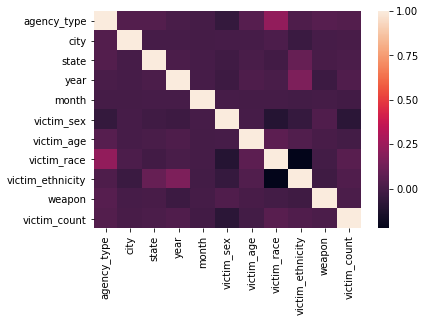

In [25]:
#show correlation map between the remaining features to check for multicollinearity
sns.heatmap(X.corr())
plt.show()

In [26]:
#functions that will create random forests or balanced random forests
#return accuracy, f1, and precision scores
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, f1_score

def r_forestClass(xtrain, xtest, ytrain, ytest):
    rfc = RandomForestClassifier(n_estimators=10)
    rfc.fit(xtrain, ytrain)
    y_pred = rfc.predict(xtest)
    uniques = np.unique(y_pred)
    print(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), xtrain.columns), 
             reverse=True), '\n')
    print('RFC Accuracy Score: ', accuracy_score(ytest, y_pred))
    print('RFC 5 Cross Validation Scores: ', cross_val_score(rfc, xtrain, ytrain, cv=5))
    print('RFC F1 Scores: ', f1_score(ytest, y_pred, average=None))
    print('RFC Precision Scores: ', precision_score(ytest, y_pred, average=None))
    print('RFC Precision Labels: ', uniques)
    
def r_forestBalance(xtrain, xtest, ytrain, ytest):
    rfc = RandomForestClassifier(n_estimators=10, class_weight='balanced') 
    rfc.fit(xtrain, ytrain)
    y_pred = rfc.predict(xtest)
    uniques = np.unique(y_pred)
    print(sorted(zip(map(lambda x: round(x, 4), rfc.feature_importances_), xtrain.columns), 
             reverse=True), '\n')
    print('RFC Accuracy Score: ', accuracy_score(ytest, y_pred))
    print('RFC 5 Cross Validation Scores: ', cross_val_score(rfc, xtrain, ytrain, cv=5))
    print('RFC F1 Scores: ', f1_score(ytest, y_pred, average=None))
    print('RFC Precision Scores: ', precision_score(ytest, y_pred, average=None)) 
    print('RFC Precision Labels: ', uniques)

In [27]:
r_forestClass(Xrace_train, Xrace_test, yrace_train, yrace_test)

[(0.5105, 'victim_race'), (0.1081, 'victim_age'), (0.082, 'year'), (0.0741, 'city'), (0.0677, 'month'), (0.0522, 'state'), (0.039, 'victim_ethnicity'), (0.0312, 'weapon'), (0.0186, 'agency_type'), (0.0098, 'victim_count'), (0.0069, 'victim_sex')] 

RFC Accuracy Score:  0.8564749547999649
RFC 5 Cross Validation Scores:  [0.85803765 0.85759391 0.85697462 0.85811572 0.85874482]
RFC F1 Scores:  [0.58775765 0.86031008 0.52654867 0.86431291]
RFC Precision Scores:  [0.63495277 0.86768404 0.62962963 0.8540793 ]
RFC Precision Labels:  ['Asian/Pacific Islander' 'Black' 'Indigenous' 'White']


In [28]:
r_forestBalance(Xrace_train, Xrace_test, yrace_train, yrace_test)

[(0.4025, 'victim_race'), (0.104, 'victim_age'), (0.1029, 'state'), (0.0993, 'city'), (0.0959, 'year'), (0.0693, 'month'), (0.0417, 'weapon'), (0.0317, 'agency_type'), (0.026, 'victim_ethnicity'), (0.0139, 'victim_count'), (0.0127, 'victim_sex')] 

RFC Accuracy Score:  0.8578289646603426
RFC 5 Cross Validation Scores:  [0.85907873 0.85740617 0.85746958 0.85978836 0.85848879]
RFC F1 Scores:  [0.56618113 0.86200134 0.50436808 0.86589847]
RFC Precision Scores:  [0.6216968  0.87023895 0.65112782 0.85403612]
RFC Precision Labels:  ['Asian/Pacific Islander' 'Black' 'Indigenous' 'White']


In [29]:
r_forestClass(Xsex_train, Xsex_test, ysex_train, ysex_test)

[(0.229, 'victim_age'), (0.1892, 'city'), (0.1668, 'year'), (0.14, 'month'), (0.1201, 'state'), (0.0683, 'weapon'), (0.0252, 'agency_type'), (0.0198, 'victim_race'), (0.0197, 'victim_ethnicity'), (0.0126, 'victim_sex'), (0.0094, 'victim_count')] 

RFC Accuracy Score:  0.8751682556370617
RFC 5 Cross Validation Scores:  [0.87457332 0.8716719  0.87371781 0.87243775 0.87323775]
RFC F1 Scores:  [0.24434695 0.93196449]
RFC Precision Scores:  [0.38225977 0.90264371]
RFC Precision Labels:  ['Female' 'Male']


In [30]:
r_forestBalance(Xsex_train, Xsex_test, ysex_train, ysex_test)

[(0.2376, 'victim_age'), (0.1671, 'city'), (0.1567, 'year'), (0.1273, 'month'), (0.108, 'state'), (0.0831, 'weapon'), (0.0298, 'victim_race'), (0.0271, 'agency_type'), (0.0256, 'victim_ethnicity'), (0.0235, 'victim_sex'), (0.0141, 'victim_count')] 

RFC Accuracy Score:  0.8765143007335547
RFC 5 Cross Validation Scores:  [0.87552908 0.87549495 0.87598778 0.87557816 0.87690732]
RFC F1 Scores:  [0.22316865 0.93292609]
RFC Precision Scores:  [0.38094424 0.90071591]
RFC Precision Labels:  ['Female' 'Male']


In [31]:
r_forestClass(Xage_train, Xage_test, yage_train, yage_test)

[(0.2061, 'victim_age'), (0.1862, 'city'), (0.1678, 'year'), (0.157, 'month'), (0.1284, 'state'), (0.0626, 'weapon'), (0.0239, 'victim_ethnicity'), (0.0231, 'agency_type'), (0.0194, 'victim_count'), (0.0149, 'victim_race'), (0.0105, 'victim_sex')] 

RFC Accuracy Score:  0.41763239428767135
RFC 5 Cross Validation Scores:  [0.41602526 0.41611769 0.41506375 0.41395849 0.41517034]
RFC F1 Scores:  [0.56503674 0.38124582 0.24741816 0.17145714 0.10464928 0.12329302
 0.34687299 0.12824765]
RFC Precision Scores:  [0.50142496 0.37489041 0.28501104 0.24137931 0.19840295 0.25079365
 0.49539595 0.34730539]
RFC Precision Labels:  ['15 - 24' '25 - 34' '35 - 44' '45 - 54' '55 - 64' '65 - 74' 'Over 75'
 'Under 15']


In [32]:
r_forestBalance(Xage_train, Xage_test, yage_train, yage_test)

[(0.2623, 'victim_age'), (0.1703, 'city'), (0.1518, 'year'), (0.133, 'month'), (0.1205, 'state'), (0.0644, 'weapon'), (0.0243, 'agency_type'), (0.0235, 'victim_ethnicity'), (0.0196, 'victim_race'), (0.0166, 'victim_count'), (0.0138, 'victim_sex')] 

RFC Accuracy Score:  0.41746513424609527
RFC 5 Cross Validation Scores:  [0.41126376 0.41589583 0.41405677 0.41247354 0.41576773]
RFC F1 Scores:  [0.56266797 0.37859178 0.25043807 0.16843315 0.09892262 0.15336707
 0.37151703 0.12992782]
RFC Precision Scores:  [0.49704444 0.37123446 0.29438305 0.24691127 0.19165085 0.30974843
 0.49423394 0.35889571]
RFC Precision Labels:  ['15 - 24' '25 - 34' '35 - 44' '45 - 54' '55 - 64' '65 - 74' 'Over 75'
 'Under 15']


In [33]:
#create logistic regression models
from sklearn.linear_model import LogisticRegression

def log_reg(xtrain, xtest, ytrain, ytest):
    logr = LogisticRegression(class_weight='balanced')
    logr.fit(xtrain, ytrain)
    y_pred = logr.predict(xtest)
    uniques = np.unique(y_pred)
    print('LogReg Accuracy Score: ', accuracy_score(ytest, y_pred))
    print('LogReg 5 Cross Validation Scores: ', cross_val_score(logr, xtrain, ytrain, cv=5))
    print('LogReg F1 Scores: ', f1_score(ytest, y_pred, average=None))
    print('LogReg Precision Scores: ', precision_score(ytest, y_pred, average=None))
    print('LogReg Precision Labels: ', uniques)

In [34]:
log_reg(Xrace_train, Xrace_test, yrace_train, yrace_test)

LogReg Accuracy Score:  0.8577811760770352
LogReg 5 Cross Validation Scores:  [0.85993207 0.85875446 0.85970542 0.8599249  0.85961529]
LogReg F1 Scores:  [0.01533742 0.85534441 0.12698413 0.8792081 ]
LogReg Precision Scores:  [0.06355932 0.87007812 0.52413793 0.85082498]
LogReg Precision Labels:  ['Asian/Pacific Islander' 'Black' 'Indigenous' 'White']


In [35]:
log_reg(Xsex_train, Xsex_test, ysex_train, ysex_test)

LogReg Accuracy Score:  0.5240416397855886
LogReg 5 Cross Validation Scores:  [0.52118037 0.52179478 0.52392006 0.52794798 0.52401434]
LogReg F1 Scores:  [0.22072401 0.65739414]
LogReg Precision Scores:  [0.13525219 0.91030628]
LogReg Precision Labels:  ['Female' 'Male']


In [36]:
log_reg(Xage_train, Xage_test, yage_train, yage_test)

LogReg Accuracy Score:  0.3501230556020167
LogReg 5 Cross Validation Scores:  [0.34154791 0.34136601 0.34590637 0.34571926 0.34566805]
LogReg F1 Scores:  [0.58324789 0.18222756 0.10265105 0.06749847 0.03591369 0.04636974
 0.10482568 0.05951733]
LogReg Precision Scores:  [0.47690845 0.30720567 0.25170068 0.11387164 0.05715658 0.03034174
 0.05682103 0.04063429]
LogReg Precision Labels:  ['15 - 24' '25 - 34' '35 - 44' '45 - 54' '55 - 64' '65 - 74' 'Over 75'
 'Under 15']


In [37]:
#create sdg classifer models
from sklearn.linear_model import SGDClassifier

def sgd_class(xtrain, xtest, ytrain, ytest):
    sgd = SGDClassifier(max_iter=100, class_weight='balanced')
    sgd.fit(xtrain, ytrain)
    y_pred = sgd.predict(xtest)
    uniques = np.unique(y_pred)
    print('SGD Accuracy Score: ', accuracy_score(ytest, y_pred))
    print('SGD 5 Cross Validation Scores: ', cross_val_score(sgd, xtrain, ytrain, cv=5))
    print('SGD F1 Scores: ', f1_score(ytest, y_pred, average=None))
    print('SGD Precision Scores: ', precision_score(ytest, y_pred, average=None))
    print('SGD Precision Labels: ', uniques)

In [38]:
import warnings
warnings.filterwarnings("ignore")

In [39]:
sgd_class(Xrace_train, Xrace_test, yrace_train, yrace_test)

SGD Accuracy Score:  0.8585378286460698
SGD 5 Cross Validation Scores:  [0.85933473 0.00844811 0.85967128 0.00844854 0.65824643]
SGD F1 Scores:  [0.02837684 0.85655417 0.00365631 0.87865258]
SGD Precision Scores:  [0.5952381  0.86729082 0.04761905 0.85168223]
SGD Precision Labels:  ['Asian/Pacific Islander' 'Black' 'Indigenous' 'White']


In [40]:
sgd_class(Xsex_train, Xsex_test, ysex_train, ysex_test)

SGD Accuracy Score:  0.11239874793911735
SGD 5 Cross Validation Scores:  [0.11339432 0.11339432 0.88662081 0.32216552 0.86752005]
SGD F1 Scores:  [0.20208356 0.        ]
SGD Precision Scores:  [0.11239875 0.        ]
SGD Precision Labels:  ['Female']


In [41]:
sgd_class(Xage_train, Xage_test, yage_train, yage_test)

SGD Accuracy Score:  0.2476563682269639
SGD 5 Cross Validation Scores:  [0.21807321 0.31491279 0.37976822 0.02833345 0.0149348 ]
SGD F1 Scores:  [0.02239323 0.38352567 0.2792996  0.         0.         0.
 0.12200655 0.004561  ]
SGD Precision Scores:  [0.55055055 0.30581777 0.18916692 0.         0.         0.
 0.08178439 0.01433692]
SGD Precision Labels:  ['15 - 24' '25 - 34' '35 - 44' '65 - 74' 'Over 75' 'Under 15']


It looks like our balanced random forest model is the most effective and accurate in making predictions. 

In [42]:
#apply the same protocols to our unsolved homiside dataframe
test_features = test.drop(['perpetrator_sex', 'perpetrator_age', 'perpetrator_race', 'perpetrator_ethnicity',
            'relationship', 'perpetrator_count', 'crime_solved', 'crime_type', 'record_source', 'perp_age_bracket'], 1)

y_race_test = test.perpetrator_race
y_age_test = test.perp_age_bracket
y_sex_test = test.perpetrator_sex

for column in test_features.select_dtypes(['category', object]):
    test_features[column] = le.fit_transform(test_features[column])
    

#X_race_train, X_race_test, y_race_train, y_race_test = train_test_split(test_features, y_race_test, test_size=0.3)
#X_age_train, X_age_test, y_age_train, y_age_test = train_test_split(test_features, y_age_test, test_size=0.3)
#X_sex_train, X_sex_test, y_sex_train, y_sex_test = train_test_split(test_features, y_sex_test, test_size=0.3)

In [43]:
#save the model predictions from the RFC for race, sex and age range
rfc_race = RandomForestClassifier(n_estimators=10)
rfc_race.fit(Xrace_train, yrace_train)
race_pred = rfc_race.predict(test_features)

rfc_sex = RandomForestClassifier(n_estimators=10)
rfc_sex.fit(Xsex_train, ysex_train)
sex_pred = rfc_sex.predict(test_features)

rfc_age = RandomForestClassifier(n_estimators=10)
rfc_age.fit(Xage_train, yage_train)
age_pred = rfc_age.predict(test_features)

In [44]:
test['Race Prediction'] = race_pred
test['Sex Prediction'] = sex_pred
test['Age Bracket Prediction'] = age_pred

In [45]:
test = test.drop(['perpetrator_sex', 'perpetrator_age', 'perpetrator_race', 'perpetrator_ethnicity', 'perp_age_bracket'], 1)

In [46]:
test.iloc[9551]

agency_type                     Municipal Police
city                                   Middlesex
state                                 New Jersey
year                                        1981
month                                   February
crime_type                Murder or Manslaughter
crime_solved                                  No
victim_sex                                  Male
victim_age                                    29
victim_race                                White
victim_ethnicity                         Unknown
relationship                             Unknown
weapon                                   Handgun
victim_count                                   0
perpetrator_count                              0
record_source                                FBI
Race Prediction                            Black
Sex Prediction                              Male
Age Bracket Prediction                   25 - 34
Name: 35865, dtype: object

In [47]:
#set up train and test sets from an under sampled data selection
from imblearn.under_sampling import RandomUnderSampler
#random undersampler
rus = RandomUnderSampler(return_indices=True)
X_resampled, y_resampled, idx_resampled = rus.fit_sample(X, y_race)
#train test split
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled,
                                                                                            y_resampled, test_size=0.3)
#take a look at the size of our under sampled data sets
print(X_train_resampled.shape)

(9872, 11)


## Population undersampling

It could be that some of our demographics are under represented. Let's change our sampling distribution with an undersampler to see if that will effect our models.

In [48]:
#set up train and test sets from an under sampled data selection
from imblearn.under_sampling import RandomUnderSampler
#random undersampler
rus1 = RandomUnderSampler(return_indices=True)
Xs_resampled, ys_resampled, idxs_resampled = rus1.fit_sample(X, y_sex)
#train test split
Xs_train_resampled, Xs_test_resampled, ys_train_resampled, ys_test_resampled = train_test_split(Xs_resampled,
                                                                                            ys_resampled, test_size=0.3)
#take a look at the size of our under sampled data sets
print(Xs_train_resampled.shape)

(66260, 11)


In [49]:
#undersampled race
rfc8 = RandomForestClassifier(n_estimators=100)
rfc8.fit(X_train_resampled, y_train_resampled)
y_pred8 = rfc8.predict(X_test_resampled)
uniques = np.unique(y_pred8)
print('RFC Accuracy Score: ', accuracy_score(y_test_resampled, y_pred8))
print('RFC 5 Cross Validation Scores: ', cross_val_score(rfc8, X_train_resampled, y_train_resampled, cv=5))
print('RFC F1 Scores: ', f1_score(y_test_resampled, y_pred8, average=None))
print('RFC Precision Scores: ', precision_score(y_test_resampled, y_pred8, average=None))
print('RFC Precision Labels: ', uniques)

RFC Accuracy Score:  0.7660680529300568
RFC 5 Cross Validation Scores:  [0.75366717 0.75481256 0.7674772  0.77862209 0.76533198]
RFC F1 Scores:  [0.80213904 0.82253771 0.77962683 0.67204073]
RFC Precision Scores:  [0.86705202 0.80678851 0.85132159 0.60458015]
RFC Precision Labels:  ['Asian/Pacific Islander' 'Black' 'Indigenous' 'White']


In [50]:
#undersampled sex
rfc4 = RandomForestClassifier(n_estimators=100)
rfc4.fit(Xs_train_resampled, ys_train_resampled)
y_pred4 = rfc4.predict(Xs_test_resampled)
uniques = np.unique(y_pred4)
print('RFC Accuracy Score: ', accuracy_score(ys_test_resampled, y_pred4))
print('RFC 5 Cross Validation Scores: ', cross_val_score(rfc4, Xs_train_resampled, ys_train_resampled, cv=5))
print('RFC F1 Scores: ', f1_score(ys_test_resampled, y_pred4, average=None))
print('RFC Precision Scores: ', precision_score(ys_test_resampled, y_pred4, average=None))
print('RFC Precision Labels: ', uniques)

RFC Accuracy Score:  0.6931121909993662
RFC 5 Cross Validation Scores:  [0.69431029 0.69491398 0.69348023 0.69046182 0.69212194]
RFC F1 Scores:  [0.69256006 0.69366234]
RFC Precision Scores:  [0.69087838 0.69534884]
RFC Precision Labels:  ['Female' 'Male']


In [51]:
#logistic regression with undersampled race
logr8 = LogisticRegression()
logr8.fit(X_train_resampled, y_train_resampled)
y_pred7 = logr8.predict(X_test_resampled)
uniques = np.unique(y_pred7)
print('RFC Accuracy Score: ', accuracy_score(y_test_resampled, y_pred7))
print('RFC 5 Cross Validation Scores: ', cross_val_score(logr8, X_train_resampled, y_train_resampled, cv=5))
print('RFC F1 Scores: ', f1_score(y_test_resampled, y_pred7, average=None))
print('RFC Precision Scores: ', precision_score(y_test_resampled, y_pred7, average=None))
print('RFC Precision Labels: ', uniques)

RFC Accuracy Score:  0.5295368620037807
RFC 5 Cross Validation Scores:  [0.52807284 0.52988855 0.52431611 0.54407295 0.54333502]
RFC F1 Scores:  [0.51837889 0.48659004 0.41183879 0.64216054]
RFC Precision Scores:  [0.49239033 0.51678535 0.6374269  0.52872143]
RFC Precision Labels:  ['Asian/Pacific Islander' 'Black' 'Indigenous' 'White']


## Results

Overall the standard **Random Forest Classifier** consistantly had the highest F1 scores across all demographic classes. Race was accurately predicted 86.6% of the time, sex was accuratly predicted 88.4% of the time, and age brackets were predicted correctly 43.4% of the time. The other two types of models were not able to provide predictions for the more rare classes of demographics, and were not more accurate for the major classes. Undersampling did improve the model's ability to predict rarer demographic groups, however it brought down significantly the models' ability to predict the major classes. Therefore, I believe the undersampled populations were not helpful.